In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gfapy
from dimod.reference.samplers import SimulatedAnnealingSampler
from dimod import BinaryQuadraticModel
from dwave.system import LeapHybridSampler

In [2]:
g = nx.DiGraph()
g.add_nodes_from([
    (0, {"weight": 1}),
    (1, {"weight": 1}),
    (2, {"weight": 1}),
    (3, {"weight": 1}),
    (4, {"weight": 1}),
    # (5, {"weight": 1}),
])
g.add_edges_from([
    (0, 1),
    (1, 2),
    (1, 3),
    (1, 4),
    (2, 1),
    (2, 3),
    (2, 4),
    (3, 1),
    (3, 2),
    (3, 4),
])

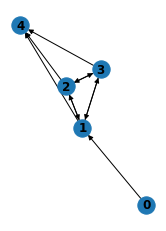

In [3]:
subax1 = plt.subplot(121)
nx.draw(g, with_labels=True, font_weight='bold')

In [4]:
def setup_graph(graph, t_max):
    graph_copy = nx.DiGraph(graph)
    # Add virtual node to allow early finishes
    graph_copy.add_nodes_from(
        [(len(list(graph.nodes)), {"weight": t_max})],
    )    
    nodes = list(graph_copy.nodes)
    graph_copy.add_edges_from([
        (nodes[-1], nodes[-1]),
        (nodes[-2], nodes[-1])
    ])
    edges = list(graph_copy.edges)
    return graph_copy, nodes, edges

In [5]:
def tangle_problem_bqm(graph: nx.Graph, lamda, mu) -> BinaryQuadraticModel:
    """Returns a Binary Quadratic Model for the tangle problem.
    
    The tangle problem is to find the longest path through a node-weighted graph, where any node can be visited at most its weight many times.

    Args:
        graph (nx.Graph): the node-weighted graph which underlies the tangle problem
    """
    bqm = BinaryQuadraticModel({}, {}, 0, "BINARY")
    P = 10
    t_max = sum(graph.nodes.data()[i]["weight"] for i in range(len(graph.nodes))) + 1
    
    new_graph, nodes, edges = setup_graph(graph, t_max)
    
    # Reward travelling along true edges; penalise travelling not along edges
    for t in range(t_max - 1):
        for i in range(len(nodes)):        
            for j in range(len(nodes)):
                bqm.add_interaction(
                    (i, t), 
                    (j, t + 1), 
                    -1 if ((i, j) in edges) else P
                )
        # Travelling the virtual edges should not be rewarded
        bqm.add_interaction((nodes[-2], t), (nodes[-1], t + 1), 1)
        bqm.add_interaction((nodes[-1], t), (nodes[-1], t + 1), 1)
    
    # Penalise not starting at start or ending at end
    bqm.add_linear((nodes[0], 0), -P)
    bqm.add_linear((nodes[-1], t_max - 1), -P)
    bqm.offset += 2 * P
    
    # Penalise multiple locations at one time
    for t in range(t_max):
        bqm.offset += P
        for i in range(len(nodes)): 
            bqm.add_linear((i, t), -P)
            for j in range(i):
                bqm.add_interaction((i, t), (j, t), 2 * P) 
                
    # Generalised Lagrangian Penalties
    for i in range(len(nodes) - 1):
        weight = new_graph.nodes.data()[i]["weight"]
        bqm.offset += mu / 2 * weight ** 2 - lamda[i] * weight
        for t in range(t_max):
            bqm.add_linear((i, t), mu / 2 * (1 - 2 * weight) + lamda[i])
            for t2 in range(t):
                bqm.add_interaction(
                    (i, t),
                    (i, t2),
                    mu
                )
    
    return bqm
    

In [6]:
def get_path(sample):
    return sorted([i for i in list(sample.keys()) if sample[i]], key=lambda e: e[1])

In [7]:
def sample_tangle_problem(graph, sampler, lamda, mu):
    bqm = tangle_problem_bqm(graph, lamda, mu)
    sampleset = sampler.sample(bqm, num_reads=30)
    best_sample = sampleset.first.sample
    best_energy = sampleset.first.energy
    return best_sample, best_energy

In [8]:
def get_node_visits(sample):
    path = get_path(sample)
    node_visits = {x : 0 for x in list(g.nodes)}
    node_visits[len(list(g.nodes))] = 0
    for path_node in path:
        node_visits[path_node[0]] += 1
        
    return node_visits

In [9]:
def get_constraint_values(node_visits, graph):
    constraint_values = np.array([node_visits[x] - graph.nodes.data()[x]['weight'] for x in list(graph.nodes)])
    return constraint_values

In [10]:
def tangle_problem_iteration(graph, sampler, lamda, mu):
    best_sample, best_energy = sample_tangle_problem(graph, sampler, lamda, mu)
    node_visits = get_node_visits(best_sample)
    constraint_values = get_constraint_values(node_visits, graph)
    return best_sample, best_energy, constraint_values

In [11]:
def tangle_problem(graph, sampler=None, lamda=np.array([0] * len(list(g.nodes)), dtype=float), mu=0.5):
    """Solve the tangle problem using the generalised Lagrangian method.

    Args:
        graph: node-weighted graph underlying the tangle problem.
        sampler (SamplerABCMeta, optional): The sampler to use. Defaults to None.
        lamda (np.ndarray, optional): Initial values for the linear Lagrangian terms. Defaults to [0]*len(list(g.nodes)).
        mu (int, optional): Initial value for the quadratic Lagrangian terms. Defaults to 0.5.

    Returns:
        (dict, float64, list, float): Returns the best variable assignment and the corresponding energy as well as the lagrangian variable values.
    """
    if sampler is None:
        sampler = SimulatedAnnealingSampler()
        
    best_sample, best_energy, constraint_values = tangle_problem_iteration(graph, sampler, lamda, mu)
    print(f'Best path={get_path(best_sample)}\nBest energy={best_energy}\nConstraint values={constraint_values}\n')
    while not all(constraint_values <= 0):
        lamda += (constraint_values > 0) * mu * constraint_values
        mu *= 1.1
        
        best_sample, best_energy, constraint_values = tangle_problem_iteration(graph, sampler, lamda, mu)
        print(f'Best path={get_path(best_sample)}\nBest energy={best_energy}\nConstraint values={constraint_values}\n')

    return best_sample, best_energy, lamda, mu

In [12]:
tangle_sample, tangle_energy, lamda, mu = tangle_problem(g)

Best path=[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]
Best energy=-4.0
Constraint values=[0 0 0 0 0]



In [13]:
p = get_path(tangle_sample)
c = get_constraint_values(get_node_visits(tangle_sample), g)

In [20]:
bqm_test = tangle_problem_bqm(g, np.array([0] * len(list(g.nodes))), 0.5)
sample_like = {var : 0 for var in bqm_test.variables}
opt_path = [(0, 0), (1, 1), (2, 2), (1, 3), (3, 4), (1, 5), (4, 6), (5, 7), (5, 8)]
for node in opt_path:
    sample_like[node] = 1

e = bqm_test.energy(sample_like)
nv = get_node_visits(sample_like)
cv = get_constraint_values(nv, g)
bqm_test.quadratic

{((0, 1), (0, 0)): 10.5, ((1, 1), (0, 0)): -1.0, ((1, 1), (0, 1)): 20.0, ((2, 1), (0, 0)): 10.0, ((2, 1), (0, 1)): 20.0, ((2, 1), (1, 1)): 20.0, ((3, 1), (0, 0)): 10.0, ((3, 1), (0, 1)): 20.0, ((3, 1), (1, 1)): 20.0, ((3, 1), (2, 1)): 20.0, ((4, 1), (0, 0)): 10.0, ((4, 1), (0, 1)): 20.0, ((4, 1), (1, 1)): 20.0, ((4, 1), (2, 1)): 20.0, ((4, 1), (3, 1)): 20.0, ((5, 1), (0, 0)): 10.0, ((5, 1), (0, 1)): 20.0, ((5, 1), (1, 1)): 20.0, ((5, 1), (2, 1)): 20.0, ((5, 1), (3, 1)): 20.0, ((5, 1), (4, 1)): 20.0, ((1, 0), (0, 0)): 20.0, ((1, 0), (0, 1)): 10.0, ((1, 0), (1, 1)): 10.5, ((1, 0), (2, 1)): -1.0, ((1, 0), (3, 1)): -1.0, ((1, 0), (4, 1)): -1.0, ((1, 0), (5, 1)): 10.0, ((2, 0), (0, 0)): 20.0, ((2, 0), (0, 1)): 10.0, ((2, 0), (1, 1)): -1.0, ((2, 0), (2, 1)): 10.5, ((2, 0), (3, 1)): -1.0, ((2, 0), (4, 1)): -1.0, ((2, 0), (5, 1)): 10.0, ((2, 0), (1, 0)): 20.0, ((3, 0), (0, 0)): 20.0, ((3, 0), (0, 1)): 10.0, ((3, 0), (1, 1)): -1.0, ((3, 0), (2, 1)): -1.0, ((3, 0), (3, 1)): 10.5, ((3, 0), (4, 1)

In [15]:
bqm_test.variables

Variables([(0, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5)])

In [16]:
# hybrid_sampler = LeapHybridSampler()
# q_sample = hybrid_sampler.sample(bqm_test)
# q_best = q_sample.first.sample
# q_energy = q_sample.first.energy
# q_path = get_path(q_best)

# for i in range(len(q_path) - 1):
#     print(bqm_test.get_quadratic(q_path[i], q_path[i+1]))

# q_constraints = get_constraint_values(get_node_visits(q_best), g)

In [17]:
filename = "../tangle/data/mafft+cons_clean.gfa"

In [18]:
def graph_from_file(filename):
    gfa = gfapy.Gfa.from_file(filename)
    digraph = nx.DiGraph()
    for segment_line in gfa.segments:
        digraph.add_node(segment_line.name, sequence=segment_line.sequence)
    for edge_line in gfa.edges:
        digraph.add_edges_from([
            (edge_line.sid1.name, edge_line.sid2.name),
            (edge_line.sid2.name, edge_line.sid1.name),
        ])
    return digraph
    

In [19]:
di = digraph_from_file(filename)
di.edges.data()
subax1 = plt.plot()
nx.draw(di, with_labels=True)

NameError: name 'digraph_from_file' is not defined

In [ ]:
list(di.nodes)[0]

1

In [ ]:
def gfa_to_di_graph(filename):
    g = nx.DiGraph()
    with open(filename) as file:
        for line in file:
            strip_line = line.rstrip()
            if strip_line[0] == "S":
                g.add_node()

True